In [1]:
# Import libraries
import ast
import csv
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker
import pandas as pd
import glob, os
import re
import math
from tqdm import tqdm
from scipy.stats import stats
from scipy.stats import mannwhitneyu
import itertools
import seaborn as sns
import numpy.linalg as linalg

#tsne plot
from sklearn.manifold import TSNE

# To make the plot in the notebook and not in an extra window
%matplotlib notebook 

# Implement error messages (Default should be True)
error_on_missing_timestamps = False
error_on_time_light_mismatch = False
error_on_time_behavior_mismatch = False
error_on_missing_behaviors = False
error_on_invalid_behavior_range = False

In [2]:
#Open multiple .csv from single directory. Define existing behaviors. Define sample_ID and experiment_ID.
# Chris's FRAN is zero based!!, whereas old annotations are 1 based
#directory for behavior data

behavior_directories = [r'/Users/nadine/Documents/Zlatic_lab/close-loop/Notes/behavior_csv_cl_A4/'
                        #r'/Users/nadine/Documents/Zlatic_lab/close-loop/Notes/behavior_csv_cl_A9/',
                        #r'/Users/nadine/Documents/Zlatic_lab/close-loop/Notes/behavior_csv_ol/',
                        #r'/Users/nadine/Documents/Zlatic_lab/close-loop/Notes/behavior_csv_stim_artefact/'
                       ] 

behavior_files = []
for d in behavior_directories:
    behavior_files.extend(
        glob.glob(os.path.join(d, "*.csv"))) #join pathname with filename, 

# Behavior columns available in CSV files
available_behaviors = ('fw', 'bw', 'stim', 'hunch', 'turn', 'other', 'HP', 'left turn', 'right turn')

# Regular expression (define the expression filenames are searched for)
# '.' single character, matched everything, '*' 0>> occurences, '/' path delimiter, '\d' 0-9 digit,
# '+' 1>> occurences, 'L' here character from filename
# () outcome here: 2 groups, useful for extraction
# [] optional list, eg 1 --> 1
# ? character non or once 

# Behavior reg-ex (regular expression)
behavior_sample_re = re.compile('.*/(\d\d-\d\d-\d\dL\d+(-\d+)?)-behavior-(.+).csv')

# Function: readall_behavior iterates through all csv (sorted) 
# and appends the files into the list (ls) and returns dictionary
def readall_behavior(all_files, printit=False):
    data = {}
    for filename in sorted(all_files):
        # Find sample ID, file name pattern: YY-MM-DDLXDETAIL.csv,
        # exp_id = DETAIL: several measurements of same sample 
        # (cl (closeloop, RGECO/ Chronos), ol (openloop, RGECO/ Chronos), 
        # blocks (Raghav: GCaMP/Chrimson))
        # Larva ID: YY-MM-DDLX
        # Look for filename_components, which are true for pattern
        match = behavior_sample_re.match(filename)
        if not match:
            raise ValueError('Unexpected filename format: {}'.format(filename))
        filename_components = match.groups()
        #define filename_components sample_id (first group), and exp_id (sec group)
        part_sample_id, _, exp_id = filename_components         
        sample_id = "{}-{}".format(part_sample_id, exp_id)
        
        df = pd.read_csv(filename, index_col=None, header=0, delimiter = ';')
        df.fillna(0, inplace=True) #replace NaN with zero
        df['sample_id'] = sample_id  #add sample_id column
        df['exp_id'] = exp_id #add exp_id column
        data[sample_id] = df
        #Count 'True' for each column ('behavior') in each single behavior.csv)
        #print(filename, df[df == 1].count()) 
        #print(df)
    return data

behavior_data = readall_behavior(behavior_files)
#print(behavior_data['17-11-06L2-cl'])

In [3]:
# Frequency of each behavior in all imported behavior.csv by using the returned 'ls' from 
# the function readAll: concatenate the 'behavior_files' (global variable). 'True' for each 
# column ('behavior_type') in the concatenated file (df_behavior).
# Sorting has to be = False (warning message without 'sort')
df_behavior = pd.concat(behavior_data.values(), axis = 0, ignore_index = True, sort = False) #add sorting
print(df_behavior[df_behavior == 1].count()) 

START             8
END               0
fw             3479
bw              674
stim            201
hunch           301
turn           1416
other           134
HP              482
left turn       728
right turn      688
sample_id         0
exp_id            0
Unnamed: 11       0
dtype: int64


In [4]:
# Import and merge fluorescence data: Several LM files for the same sample_id exists, but differ in cell_id).
# List of LM data with two extra columns: sample_id and cell_id
# Open LM files from different directories
lightmicroscope_directories = [#r'/Users/nadine/Documents/Zlatic_lab/close-loop/Notes/Basin_traces/', 
                               #r'/Users/nadine/Documents/Zlatic_lab/close-loop/Notes/Handle-like_Traces',
                               #r'/Users/nadine/Documents/Zlatic_lab/close-loop/Notes/a00c_traces',
                               #r'/Users/nadine/Documents/Zlatic_lab/close-loop/Notes/candidate_neuron_traces',
                               r'/Users/nadine/Documents/Zlatic_lab/close-loop/Notes/All_ROI/26082017L6_allROIs_Claire/traces'
                              ] 

# Iterate through LM data and extend files in a list from within and between directory and 
# build a list of files from all directories
# (Note: append would 'extend' lists and not single files)
lightmicroscope_files = []
for d in lightmicroscope_directories:
    lightmicroscope_files.extend(
        glob.glob(os.path.join(d, "*.csv"))) #join pathname with filename

# Lightmicroscopic data reg-ex (regular expression)
lightmicroscope_sample_re = re.compile('.*/(\d\d-\d\d-\d\dL\d+(-\d+)?)-(.*)-(.*).csv')

# Function: readall_lm iterates through all LM_csv (sorted) 
# and returns a dictionary{key:value} 
# samples = {sample_id:cell-id}
def readall_lm(all_files):
    samples = {}
    for filename in sorted(all_files):
        # Find sample ID, file name pattern: YY-MM-DDLXDETAIL.csv,
        # Larva ID: YY-MM-DDLX, DETAIL = cell_id
        # Look for filename_components, which are true for pattern
        match = lightmicroscope_sample_re.match(filename)
        if not match:
            raise ValueError('Unexpected filename format: {}'.format(filename))
        filename_components = match.groups()
        part_sample_id, _, cell_id, exp_id = filename_components
        
        sample_id = "{}-{}".format(part_sample_id, exp_id)
        
        # Read LM.files 
        df = pd.read_csv(filename, index_col=None, header=0, delimiter = ',')
        # Replace NaN with zero
        df.fillna(0, inplace=True)
        
        # Add cellname to each column as prefix
        # lambda is a non defined function (longer version: def lambda(x):)
        # Rename of columns after the format cell_id, name) eg: Basin A9
        # inplace = True: column names are overwritten (if False: new dataframe)
        df.rename(lambda x: '{}_{}'.format(cell_id, x), axis = 'columns', inplace = True)
        # Get the sample_id (key) from the dictionary? to make a list [sample_cells] and 
        # if sample_id exists, append the list
        # if sample_id does not exists, start a new list
        # reminder: there can be several cell_id per sample_id
        sample_cells = samples.get(sample_id)
        if not sample_cells:
            samples[sample_id] = sample_cells = {
                'data': [],
                'exp_id': exp_id,
            }
        sample_cells['data'].append(df)
        
    return samples

lm_samples = readall_lm(lightmicroscope_files)

# New dictionary: lm_data{} to build a single dataframe with all cell_ids combined 
# for a single sample. Iterate over dict from same sample in one dataframe. 
# df.items iterate over pairs and build a list

lm_data = {}

# Iterate over all light samples and merge all found files
# for each sample into a single data frame (per sample)
for sample_id, sample_info in lm_samples.items():
    cells_dataframes = sample_info['data']
    #check if number of cells >= 1
    if not cells_dataframes:
        raise ValueError('No cells found for sample {}'.format(sample_id))
    #first element in the list
    lm_df = None

    #iteration through other df
    for cdf in cells_dataframes:
        if lm_df is None:
            lm_df = cdf
        else:
            if len(lm_df.index) != len(cdf.index):
                raise ValueError('Data frame frame to merge has not same row count as target', sample_id)
            lm_df = pd.merge(lm_df, cdf, left_index = True, right_index = True)
            
    lm_df['sample_id'] = sample_id  #add sample_id column
    lm_df['exp_id'] = sample_info['exp_id']
    lm_data[sample_id] = lm_df
#print(list(lm_data.keys()))
#print(lm_samples)

In [5]:
# Import txt-files from of the absolute time/frame from the Ca-imaging (lm-data). 
# All txt-files have to be transposed, which is a memory intensive step. After the 
# data are complete, the transposed files should be exported (ToDo). Time-data are 
# combined with sample-ID and experiment-ID.

timelapse_directory =(r'/Users/nadine/Documents/Zlatic_lab/close-loop/Notes/timelapse/') 
timelapse_files = glob.glob(os.path.join(timelapse_directory, "*.txt")) #join pathname with filename

# Behavior reg-ex (regular expression)
time_sample_re = re.compile('.*/(\d\d-\d\d-\d\dL\d+(-\d+)?)-time-(.+).txt')

# Function: readall_timelapse iterates through all txt (sorted) and appends the 
# files into the dict (data) and returns ls
def readall_time(all_files, printit=False):
    data = {}
    for filename in sorted(all_files):
        # Find sample ID, file name pattern: YY-MM-DDLXDETAIL.csv,
        # exp_id = DETAIL: several measurements of same sample (cl (closeloop), ol (openloop), blocks (Raghav))
        # Larva ID: YY-MM-DDLX
        #look for filename_components, which are true for pattern
        match = time_sample_re.match(filename)
        if not match:
            raise ValueError('Unexpected filename format: {}'.format(filename))
        filename_components = match.groups()
        part_sample_id, _, exp_id = filename_components #define filename_components sample_id (first group), and exp_id (sec group)  
        sample_id = "{}-{}".format(part_sample_id, exp_id)
        
        df = pd.read_csv(filename, header=1, index_col=None, delim_whitespace = True)
        df = df.T #transposing because read_csv imports as row
        df = df.reset_index() #transpose function sets data as index
        df.rename(columns={'index':'time'}, inplace=True) #rename reset index column to time
        df['time'] = df.time.astype(float)
        data[sample_id] = df
        
    return data

In [6]:
# Keep in mind that some of the files has to be changed because of the discrepancy in timestamps
#Will fixed this in vsc
timelapse_cache = 'timelapse.cache'

try:
    with open(timelapse_cache, 'r') as timelapse_cache_file:
        # TODO
        cache_data = timelapse_cache_file.read()
        time_data = ast.literal_eval(cache_data)
except FileNotFoundError as e:
    print('No cache file found, recomputing')
    # No cache file found, recompute
    time_data = readall_time(timelapse_files)
    # Write cache
    

No cache file found, recomputing


In [7]:
sample_data = {}

# Time data are merged into light data and checked if number length of lm = timestamp.  
# Due to technical conditions, some time.txt-file have too many or not enough time data compared
# to the corresponding LM data. The discrepancy is fixed by either dropping the extra timepoints or 
# by taking the average of the difference between each timepoint and extend the dataframe. 
# The first 10 timepoints are not included to account for instability of the microscope in 
# the beginning due to the moving parts. 
# Maximal difference between timepoints fyi.

for sample_id, sample_df in lm_data.items():
    # Add time stamps to data frame of current sample by merging
    # The time data frame for the current sample, which is expected
    # to match the light data (based on index).
    timestamp_df = time_data.get(sample_id)
    if timestamp_df is None:
        msg = '{}: could not find timestamp data for sample'.format(sample_id)
        if error_on_missing_timestamps:
            raise ValueError(msg)
        # Ignore, if missing data shouldn't cancel the whole process.
        print(msg)
        continue
        
    n_timestamps = len(timestamp_df)
    n_lightdata = len(sample_df)
    
    # The timestamp and light recordings are done by different systems.
    # This can cause the existence of additional time points/ or missing time points in a
    # dataset, which will be filtered out in the merge operation below.
    if n_lightdata != n_timestamps:
        msg = '{}: time data ({} entries) doesn\'t match light data ({} entries)'.format(
                sample_id, n_timestamps, n_lightdata)
        if error_on_time_light_mismatch:
            raise ValueError(msg)
        print(msg)
        diffs = np.diff(timestamp_df['time'])[10:] #from 10th row onwards
        diffs_avg = diffs.mean(axis=0)
        #diff between timedata and lightdata
        missing_data = len(sample_df) - len(timestamp_df)
        
        #add 'diffs_avg' to fill in missing_timedata
        if missing_data > 0:
            last_valid_index = len(timestamp_df) - 1
            last_timestamp = timestamp_df.iloc[last_valid_index]['time']
            if pd.isna(last_timestamp):
                raise ValueError('Unexpected last valid timestamp for sample {} at index {}'.format(
                        sample_id, last_valid_index))
            for i in range(0, missing_data):
                last_valid_index += 1
                timestamp_df.loc[last_valid_index] = timestamp_df.iloc[last_valid_index - 1]['time'] + diffs_avg
        elif missing_data < 0:
            drop_start = len(timestamp_df) + missing_data
            drop_end = len(timestamp_df)
            timestamp_df.drop(list(range(drop_start, drop_end)))

    # Merge timedata into light data
    # Use an 'inner' join/merge to exclude time points that don't have matching light data.
    new_sample_df = pd.merge(sample_df, timestamp_df, left_index = True, right_index = True, how='inner')
    
    # Store newly created data frame for sample (dictionary)
    sample_data[sample_id] = new_sample_df
    
print('Matched {} light data sets with their respective time points'.format(len(sample_data)))

# Max.diffs for timestamps
# diffs defined earlier
#mx = diffs.max()
#print('max-diff', mx)

#plt.hist(diffs, bins=10, alpha=0.5)
#plt.show() 

Matched 1 light data sets with their respective time points


In [8]:
# Combine behavior data with light data into a single data frame
# per sample ID. To do so, add behavior data to light data frames,
# because the light data is already organizes by frame. To accomodate
# frame ranges without an behavior data, a column named "quiet" is
# added which is True in these cases and False otherwise. Additionally,
# for each behavior column, a behavior start and end column as well as
# an overlap column is added so that parallel and successive behaviors
# of the same type can be differentiated.

for sample_id, sample_df in sample_data.items():
    sample_behavior = behavior_data.get(sample_id)
    if sample_behavior is None:
        msg = 'Could not find behavior data for sample "{}"'.format(sample_id)
        if error_on_missing_behaviors:
            raise ValueError(msg)
        print(msg)
        continue

    # Add extra columns for behavior
    for behavior in available_behaviors:
        sample_df[behavior] = False
        sample_df['{}_start'.format(behavior)] = False
        sample_df['{}_end'.format(behavior)] = False
        sample_df['{}_overlap'.format(behavior)] = False
    
    # Add 'quiet' column. Set it initially to True and mark frames
    # with actual behavior as quiet = False.
    sample_df['quiet'] = True
    
    n_light_entries = len(sample_df)

    # Iterate over behavior data and add data to target data frame
    for i, row in sample_behavior.iterrows():
        # Start and end are 1-based, make them 0-based
        start = int(row['START'])
        end = int(row['END'])
        
        if type(row['START']) == str:
            print(sample_id)
            print(start, end)
        
        if start >= end:
            msg = "{}: start ({}) needs to be strictly smaller than end ({})".format(sample_id, start, end)
            if error_on_invalid_behavior_range:
                raise ValueError(msg)
            print(msg)
            continue
        
        # Make sure we capture start/end times that are a fractional number.
        if row['START'] - start > 0 or row['END'] - end > 0:
            raise ValueError('{}: start and end frame number can\'t contain fractions'.format(sample_id))
            
        # Ignore behavior entries with an end frame higher than available light data.
        # The behavior data is one-based, which is why a strict larger than test should
        # be correct.
        if end > n_light_entries:
            msg = 'Sample: {} - Behavior row with range {}-{} exceeds light time points ({}): {}'.format(
                sample_id, start, end, n_light_entries, row)
            if error_on_time_behavior_mismatch:
                raise ValueError(msg)
            print(msg)
            continue
            
        # Find behavior observed in row
        observed_behaviors = []
        for behavior in available_behaviors:
            if row[behavior]:
                observed_behaviors.append(behavior)
        
        # We assume that not more than two behaviors are observed at the same time
        if len(observed_behaviors) > 2:
            raise ValueError('Found multiple behaviors in row {} of sample {}'.format(i, sample_id))
        
        # Add observed behavior information to target data frames in all
        # rows in behavior range.
        for b in observed_behaviors:
            # Iterate over frames valid for current behavior. Every valid
            # frame is mapped into the canonical (light/cell) data frame,
            # which is 0-indexed.
            for j in range(start, end + 1):
                # Behavior ranges are 1-indexed
                current_frame = j - 1
                # If the current behavior has already been observed at this frame,
                # set overlap to True, because we are about to mark this behavior
                # again as observed for this frame.
                if sample_df.at[current_frame, b]:
                    sample_df.at[current_frame, '{}_overlap'.format(b)] = True
                else:
                    sample_df.at[current_frame, b] = True
                
                # Mark this row as not quiet, because we observed
                # a behavior in the current frame.
                sample_df.at[current_frame, 'quiet'] = False

            sample_df.at[start - 1, '{}_start'.format(b)] = True
            sample_df.at[end - 1, '{}_end'.format(b)] = True
            
    # Mark quiet ranges with _start, _end and _overlap. By definion,
    # quiet_overlap is always False.
    sample_df['quiet_start'] = False
    sample_df['quiet_end'] = False
    sample_df['quiet_overlap'] = False
    last_sample_idx = n_light_entries - 1
    for i, row in sample_df.iterrows():
        sample_df.at[i, 'quiet_start'] = row['quiet'] and (i == 0 or not sample_df.at[i - 1, 'quiet'])
        sample_df.at[i, 'quiet_end'] = row['quiet'] and (i == last_sample_idx or not sample_df.at[i + 1, 'quiet'])


In [9]:
# Define a class with sample_id, cell_type, event_name and filter_pattern

class CellTraceConfig:
    
    def __init__(self, sample_id, cell_type, event_name, filter_pattern=None):
        self.sample_id = sample_id
        self.cell_type = cell_type
        self.event_name = event_name
        self.filter_pattern = filter_pattern
        
    def get_filter_regex(self):
        filter_regex = '^{}_'.format(self.cell_type)
        if self.filter_pattern:
            filter_regex += '.*{}.*'.format(self.filter_pattern)
        return filter_regex
    
    def get_event_start_col(self):
        return '{}_start'.format(self.event_name)

    def add_event_time_points_to_plot(self, source_df, plot):
        for idx, row in source_df.iterrows():
            plot.annotate(self.event_name, xy=(row['time'], 1))
            plt.axvline(row['time'], color='k', linestyle='-')  
            
# Define a class with sample_id, cell_type, event_time and filter_pattern (for behavioral_transitions)
# Put '' [empty string] if you dont want any cell type

class CellTransConfig:
    
    def __init__(self, sample_id, cell_type, event_time, filter_pattern=None, first_event=None, second_event=None):
        self.sample_id = sample_id
        self.cell_type = cell_type
        self.event_time = event_time
        self.filter_pattern = filter_pattern
        self.first_event = first_event
        self.second_event = second_event
        
    def get_filter_regex(self):
        if self.cell_type is None:
            cell_str = r"[a-zA-Z0-9]+"
        else:
            cell_str = self.cell_type
            
        filter_regex = '^{}_'.format(cell_str)
        if self.filter_pattern:
            filter_regex += '.*{}.*'.format(self.filter_pattern)
        return filter_regex
    
    
    
# Define a class for filtering after behavioral_transitions for either only cell_type or filter_pattern or both.
# For example to average not only over all A00cs but all A00c_midL.

class DataFilter():
    def __init__(self, cell=None, pattern=None):
        self.cell = cell if cell is not None else '.*' # Makes argument optional
        self.pattern = pattern if pattern is not None else '.*' # Makes argument optional
        
    def get_cell_filter_regex(self):
        filter_regex = '.*_{}_.*_.*'.format(self.cell)
        return filter_regex
    
    def get_pattern_filter_regex(self):
        filter_regex = '.*_.*_{}_.*'.format(self.pattern)
        return filter_regex
    
    def get_cellpattern_filter_regex(self):
        filter_regex = '.*_{}_{}_.*'.format(self.cell, self.pattern)
        return filter_regex
        
    def __str__(self):
        return "{}_{}".format(self.cell, self.pattern)   
    
    
# Define class to group the columns after cell_type/ pattern or both using the class Datafilter

class TransitionGrouper:
    def __init__(self, transitions_df):
        self.transitions_df = transitions_df
        
        sample_ids, cells, patterns, *_ = zip(*[column.split("_") for column in self.transitions_df.columns])
        
        self.sample_ids = sorted(set(sample_ids))
        self.cells = sorted(set(cells))
        self.patterns = sorted(set(patterns))
        
    def get_regex(self, cell_name=None, pattern=None):
        data_filter = DataFilter(cell=cell_name, pattern=pattern)
        if cell_name is not None and pattern is None:
            return data_filter, data_filter.get_cell_filter_regex()
        if cell_name is not None and pattern is not None:
            return data_filter, data_filter.get_cellpattern_filter_regex()
        if cell_name is None and pattern is not None:
            return data_filter, data_filter.get_pattern_filter_regex()
        raise ValueError("Both cell_name and pattern are None! :(")
    
    def group_cells(self):
        output = dict()
        for cell_name in self.cells:
            data_filter, regex = self.get_regex(cell_name)
            cell_df = self.transitions_df.filter(regex=regex)
            output[cell_name] = (str(data_filter), cell_df)
        return output
    
    def group_patterns(self):
        output = dict()
        for pattern in self.patterns:
            data_filter, regex = self.get_regex(pattern=pattern)
            pattern_df = self.transitions_df.filter(regex=regex)
            output[pattern] = (str(data_filter), pattern_df)
        return output
    
    def group_cellpattern(self):
        output = dict()
        for cell_name, pattern in itertools.product(self.cells, self.patterns):
            data_filter, regex = self.get_regex(cell_name, pattern)
            cellpattern_df = self.transitions_df.filter(regex=regex)
            output[(cell_name, pattern)] = (str(data_filter), cellpattern_df)
        return output

# Specific after Post-transitions for multiple transition kinds, used for plotting. For multiple transition 
# events, group after transition (first, or second event) <most useful> with option to group
# after celltype, filterpattern, sample_id, observations.
class TransitionType:
    def __init__(self, sample_id=".*", cell=".*", filter_pattern=".*", n_obs=".*", first_event=".*", second_event=".*"):
        self.sample_id = sample_id
        self.cell = cell
        self.filter_pattern = filter_pattern
        self.n_obs = n_obs
        self.first_event = first_event
        self.second_event = second_event
        
        self.pattern = "{}_{}_{}_{}_{}_{}"
        
    def get_filter_regex(self, use_all=False, use_cell=False, use_sample=False, use_filter_pattern=False, use_n_obs=False, use_first_event=False, use_second_event=False):
        filter_regex = self.pattern.format(self.sample_id if use_sample or use_all else ".*",
                                          self.cell if use_cell or use_all else ".*",
                                          self.filter_pattern if use_filter_pattern or use_all else ".*",
                                          self.n_obs if use_n_obs or use_all else ".*",
                                          self.first_event if use_first_event or use_all else ".*",
                                          self.second_event if use_second_event or use_all else ".*")
        return filter_regex    
    
    


In [10]:
#########################################

In [ ]:
#for specific behavior respectively transitions

In [26]:
class PostBehaviorTransition:
        
    def __init__(self, sample_id, event, post_event, max_delay=0):
        self.sample_id = sample_id
        self.post_event = post_event
        self.event = event
        self.max_delay = max_delay

def find_behavior_before(sample_id, sample_df, first_event, second_event, 
                         max_delay=0,
                         first_event_duration=None, 
                         second_event_duration=None):
    """For the data frame of a single sample <df>, find all behaviors
    of type <first_event> that is followed by the event <second_event>,
    separated by <max_delay> time. The end of <second_event> is expected
    to happen strictly after the end of <first_event>. The start time
    of <second_event> however can overlap with the end time of <first_event>.
    In this case, the time difference is negative, and still smaller than
    <max_delay>. The start time of <second_event> can be before, at or after the
    end of <first_event>.
    """
    results = []
    first_event_start_col = '{}_start'.format(first_event)
    first_event_end_col = '{}_end'.format(first_event)
    second_event_start_col = '{}_start'.format(second_event)
    second_event_end_col = '{}_end'.format(second_event)
    second_event_overlap_col = '{}_overlap'.format(second_event)
    
    first_event_start_time = None
    first_event_end_time = None
    second_event_start_time = None
    second_event_end_time = None
    
   
    for i, row in sample_df.iterrows():
        # Look for start of second behavior and remember its time.
        if row[second_event_start_col] and not row[second_event_overlap_col]:
            #print("{} starts at {}".format(second_event, row["time"]))
            second_event_start_time = row['time']
        if row[first_event_end_col]:
            #print("{} ends at {}".format(first_event, row["time"]))
            first_event_end_time = row['time']
        if row[first_event_start_col]:
            #print("{} starts at {}".format(first_event, row["time"]))
            first_event_start_time = row['time']
        for column in sample_df.columns:
            if (first_event_start_time is not None and
                column.endswith("_start") and
                "quiet" not in column and
                column != first_event_start_col and
                column != second_event_start_col and
                first_event not in column and
                second_event not in column):
                if row[column]:
                    #print("{} ended at {}, but then found {} at {}".format(first_event, first_event_end_time, column, row["time"]))
                    first_event_start_time = None
                    first_event_end_time = None
                    second_event_start_time = None
                    second_event_end_time = None
                    
        
        # As long as we haven't collected all needed time points,
        # keep on searching.
        if None in (first_event_start_time, first_event_end_time,
                    second_event_start_time):
            continue
        
        # Define rules for event_start_time and event_end_time
        if first_event_start_time > second_event_start_time:
            continue
        if first_event_start_time > first_event_end_time:
            continue
        
        # Test if first_event_start_time = second_event_start_time
        if abs(first_event_start_time - second_event_start_time) < 0.00001:
            print('{}: start time (first) event {} and start time of (second) event {} are the same: {}'.format(
                sample_id, first_event, second_event, first_event_start_time))
            
        if second_event_end_time is None:
            for j, row in sample_df.loc[i:, :].iterrows():
                if row[second_event_end_col]:
                    second_event_end_time = row["time"]
                    break
        if second_event_end_time is None:
            print("warning: end time not found for second event")

        # Test time between first event end and second event start. If it
        # is smaller than <max_delay>, store start of second event as result.
        # The first event end time being greater than the second event start
        # time, is explicitly allowed.
        # implement event duration (for quiet)
        if (second_event_start_time - first_event_end_time) <= max_delay:
            if first_event_duration is not None and first_event_end_time - first_event_start_time < first_event_duration:
                continue
            if second_event_duration is not None and second_event_end_time - second_event_start_time < second_event_duration:
                continue
            
            results.append({
                'sample_id': sample_id,
                'first_event_start': first_event_start_time,
                'first_event_end': first_event_end_time,
                'second_event_start': second_event_start_time,
                'second_event_end': second_event_end_time,
                'first_event': first_event,
                'second_event': second_event
            })
        
        # Reset behavior tracking variables to find new pattern match.
        first_event_start_time = None
        first_event_end_time = None
        second_event_start_time = None
        second_event_end_time = None
        
    return results

# Open single samples 

behavior_transitions = [
    PostBehaviorTransition('17-08-26L6-cl', 'bw', 'turn', 0.5)
    #PostBehaviorTransition('17-08-26L6-cl', 'stim', 'bw', 4.9)
]

# Open all samples single Transitions
#behavior_transitions = [
#    PostBehaviorTransition(name, 'turn', 'bw', 2) for name in lm_data]


# Open all samples multiple Transitions
#behavior_transitions = [
    #PostBehaviorTransition(name, 'fw', 'bw', 10) for name in lm_data] + [
    #PostBehaviorTransition(name, 'bw', 'fw', 10) for name in lm_data] + [
    #PostBehaviorTransition(name, 'turn', 'turn', 10) for name in lm_data] + [
    #PostBehaviorTransition(name, 'fw', 'turn', 3) for name in lm_data] + [
    #PostBehaviorTransition(name, 'turn', 'fw', 2) for name in lm_data] + [
    #PostBehaviorTransition(name, 'bw', 'turn', 2) for name in lm_data] #+ [
    #PostBehaviorTransition(name, 'turn', 'bw', 2) for name in lm_data]


found_transitions = []
for bt in tqdm(behavior_transitions):
    sample_df = sample_data.get(bt.sample_id)
    if not any(["bw" in column for column in sample_df.columns]):
        continue
    if sample_df is None:
        raise ValueError('No data found for sample {}'.format(bt.sample_id))
    transitions = find_behavior_before(bt.sample_id, sample_df, bt.event, 
                                       bt.post_event, bt.max_delay, 
                                       first_event_duration = None, 
                                       second_event_duration = None) #For 'quiet' change *_event_duration. Defaul = None.
    
    if transitions:
        found_transitions.append(transitions)


print(len(found_transitions)) # Number of data sets 
print(sum([len(sample_transitions) for sample_transitions in found_transitions])) # Number of transitions/ not working!!
#print(found_transitions) # Transitions

100%|██████████| 1/1 [00:16<00:00, 16.67s/it]

1
9


In [66]:
# Define celltype, filter-pattern for transitions. Optional do not run regex-filter. Aligning to first event start or 
# second event start: depends on stimulus. Output: a) aligned raw values, b) aligned interpolated values.
# tqdm = progress bar

cell_Ptrans_configs = []
all_Ptrans_events = []


for sample in tqdm(found_transitions):
    for found_transition in sample:
         
        cell_Ptrans_configs.append(CellTransConfig(found_transition["sample_id"], "C_C",
                                                    found_transition["second_event_start"], 
                                                    filter_pattern = None, 
                                                    first_event=found_transition["first_event"], 
                                                    second_event=found_transition["second_event"]))

# Extract for specific time window and align several events. 
# Define timepoints pre and post an event (event_df). 
# This works for single sample or multiple samples aligned 

# Set the window range left and right from the event (in seconds)
left_half_window_size = 2 # If negative it goes further to right half (Good for skipping stimulus)
right_half_window_size = 2

# trans_df defined in pargraph before 
windows = []
n_behavior_per_sample = {}

for ctc in tqdm(cell_Ptrans_configs):
    sample_df = sample_data.get(ctc.sample_id)
    n_behavior = n_behavior_per_sample.get(ctc.sample_id, 1)
    n_behavior_per_sample.setdefault(ctc.sample_id, 1)
    if sample_df is None:
        raise ValueError('{}: could not find sample data'.format(ctc.sample_id))
        continue    
   
    # Extract columns matching our cell type and the optional filter pattern.
    cell_subset_df = sample_df.filter(regex=ctc.get_filter_regex()) #Get subset of cells 
    cell_subset_df.set_index(sample_df.time, inplace=True) #Set time to index (essential for min/max...)
    cell_subset_df.reset_index(inplace = True) # Add index and time = column
    
    n_behavior_per_sample[ctc.sample_id] += 1
    window_start = ctc.event_time - left_half_window_size
    window_end = ctc.event_time + right_half_window_size
        
    # Get subset of rows between window_start and window_end
    # Including event_start
    #trans = cell_subset_df[(cell_subset_df.time >= window_start) & (cell_subset_df.time <= window_end)]
    # Excluding event start
    trans = cell_subset_df[(cell_subset_df.time > window_start) & (cell_subset_df.time < window_end)]
    # Normalizing the data to align on beginning of selected
    # behavior (event_df = Zero) by substracting events in window
    # around start of event of interest from start of event interest.
    # Note: using ":" in event.loc[] will select "all rows" in our window.
    #trans.loc[:, 'time'] = trans['time'] - row['time']
    trans.loc[:, 'time'] = trans['time'] - ctc.event_time
    
    # Add sample_id to each column as prefix and n_behavior as suffix to distinguish events within a sample
    trans.rename(lambda x: '{}_{}_{}_{}_{}'.format(ctc.sample_id, x, n_behavior, ctc.first_event, ctc.second_event), axis = 'columns', inplace = True) 
    
    # For each event start index from 1. Only: We assume the image acquisition speed is eaqual throughout the sample
    trans.index = np.arange(1, len(trans)+1)
    
    # Rename time collum to time (Not here!!! because it messes up heatMAP. WE assume the imaging speed 
    # within a sample is identical throughout acquisition)
    #trans.rename(columns={ trans.columns[0]: 'time' }, inplace = True) 
    all_Ptrans_events.append(trans) # Append a list with all event

#print(all_Ptrans_events)    
    
# Removes first event and takes it as left_window in pd.merge_ordered and iterates than through all_events
all_Ptrans_df = all_Ptrans_events.pop(0)
for right_df in all_Ptrans_events:
    all_Ptrans_df = pd.merge(all_Ptrans_df, right_df, left_index=True, right_index=True)
print(all_Ptrans_df)

100%|██████████| 9/9 [00:02<00:00,  3.31it/s]

    17-08-26L6-cl_time_1_bw_turn  17-08-26L6-cl_C_C_1_1_bw_turn  \
1                         -1.923                       0.056371   
2                         -1.603                       0.060920   
3                         -1.283                       0.036178   
4                         -0.962                       0.069269   
5                         -0.642                       0.011153   
6                         -0.321                       0.039035   
7                          0.000                       0.049449   
8                          0.320                       0.050221   
9                          0.640                       0.033996   
10                         0.961                       0.049107   
11                         1.282                       0.034903   
12                         1.602                       0.061282   
13                         1.922                       0.054518   

    17-08-26L6-cl_C_C_10_1_bw_turn  17-08-26L6-cl_C_C_100_1_b

In [28]:
# ToDo align after behavior (not transition)

In [68]:
#mean over n events

import pdb
#print(n_behavior)

def mean_across_n_behav(df):
    """
    Given a dataframe where each column represents one of n replicates,
    and the column titles end with '_{n}', return a new dataframe
    whose columns are the means across replicates.
    """
    cell_patterns_to_n_behav = dict()
    
    # populate dict whose keys are the cell pattern prefix (i.e. sample ID, cell type, pattern)
    # and values are list of column names which are that prefix with '_{n}'
    for col in sorted(df.columns):
        split = col.split('_')
        key = "_".join(split[:-3]) #-1 (for identified celltypes)
        if key not in cell_patterns_to_n_behav:
            cell_patterns_to_n_behav[key] = []
        cell_patterns_to_n_behav[key].append(col)

    #print(cell_patterns_to_n_behav)

    out_df = pd.DataFrame(index=df.index)
    # go through the above dict, creating a new column for each key,
    # and populating that column with the mean of the columns specified
    # by the value (list of column names)
    for key, vals in cell_patterns_to_n_behav.items():
        tmp_df = df[vals]
        means = tmp_df.mean(axis=1)
        out_df[key] = means
    
    return out_df

#int_pre_mean = mean_across_n_behav(int_pre_data)
#int_post_mean = mean_across_n_behav(int_post_data)
all_Ptrans_df_mean = mean_across_n_behav(all_Ptrans_df)

#print(all_Ptrans_df.mean.columns)

def filter_cols_over_threshold(df, threshold=0.2):
    """
    Given a data frame, produce a new data frame
    only with columns which have at least one value over threshold.
    """
    
    is_over_threshold = df > 0.2

    useful_columns = []
    for col in is_over_threshold.columns:
        #pdb.set_trace() #python debugger
        if sum(is_over_threshold[col]) > 0:
            useful_columns.append(col)

    return df[useful_columns]

all_Ptrans_df_useful = filter_cols_over_threshold(all_Ptrans_df_mean)

#print(int_all_Ptrans_df_useful.columns)

In [70]:
print(all_Ptrans_df_mean.shape)

(13, 4391)


<IPython.core.display.Javascript object>


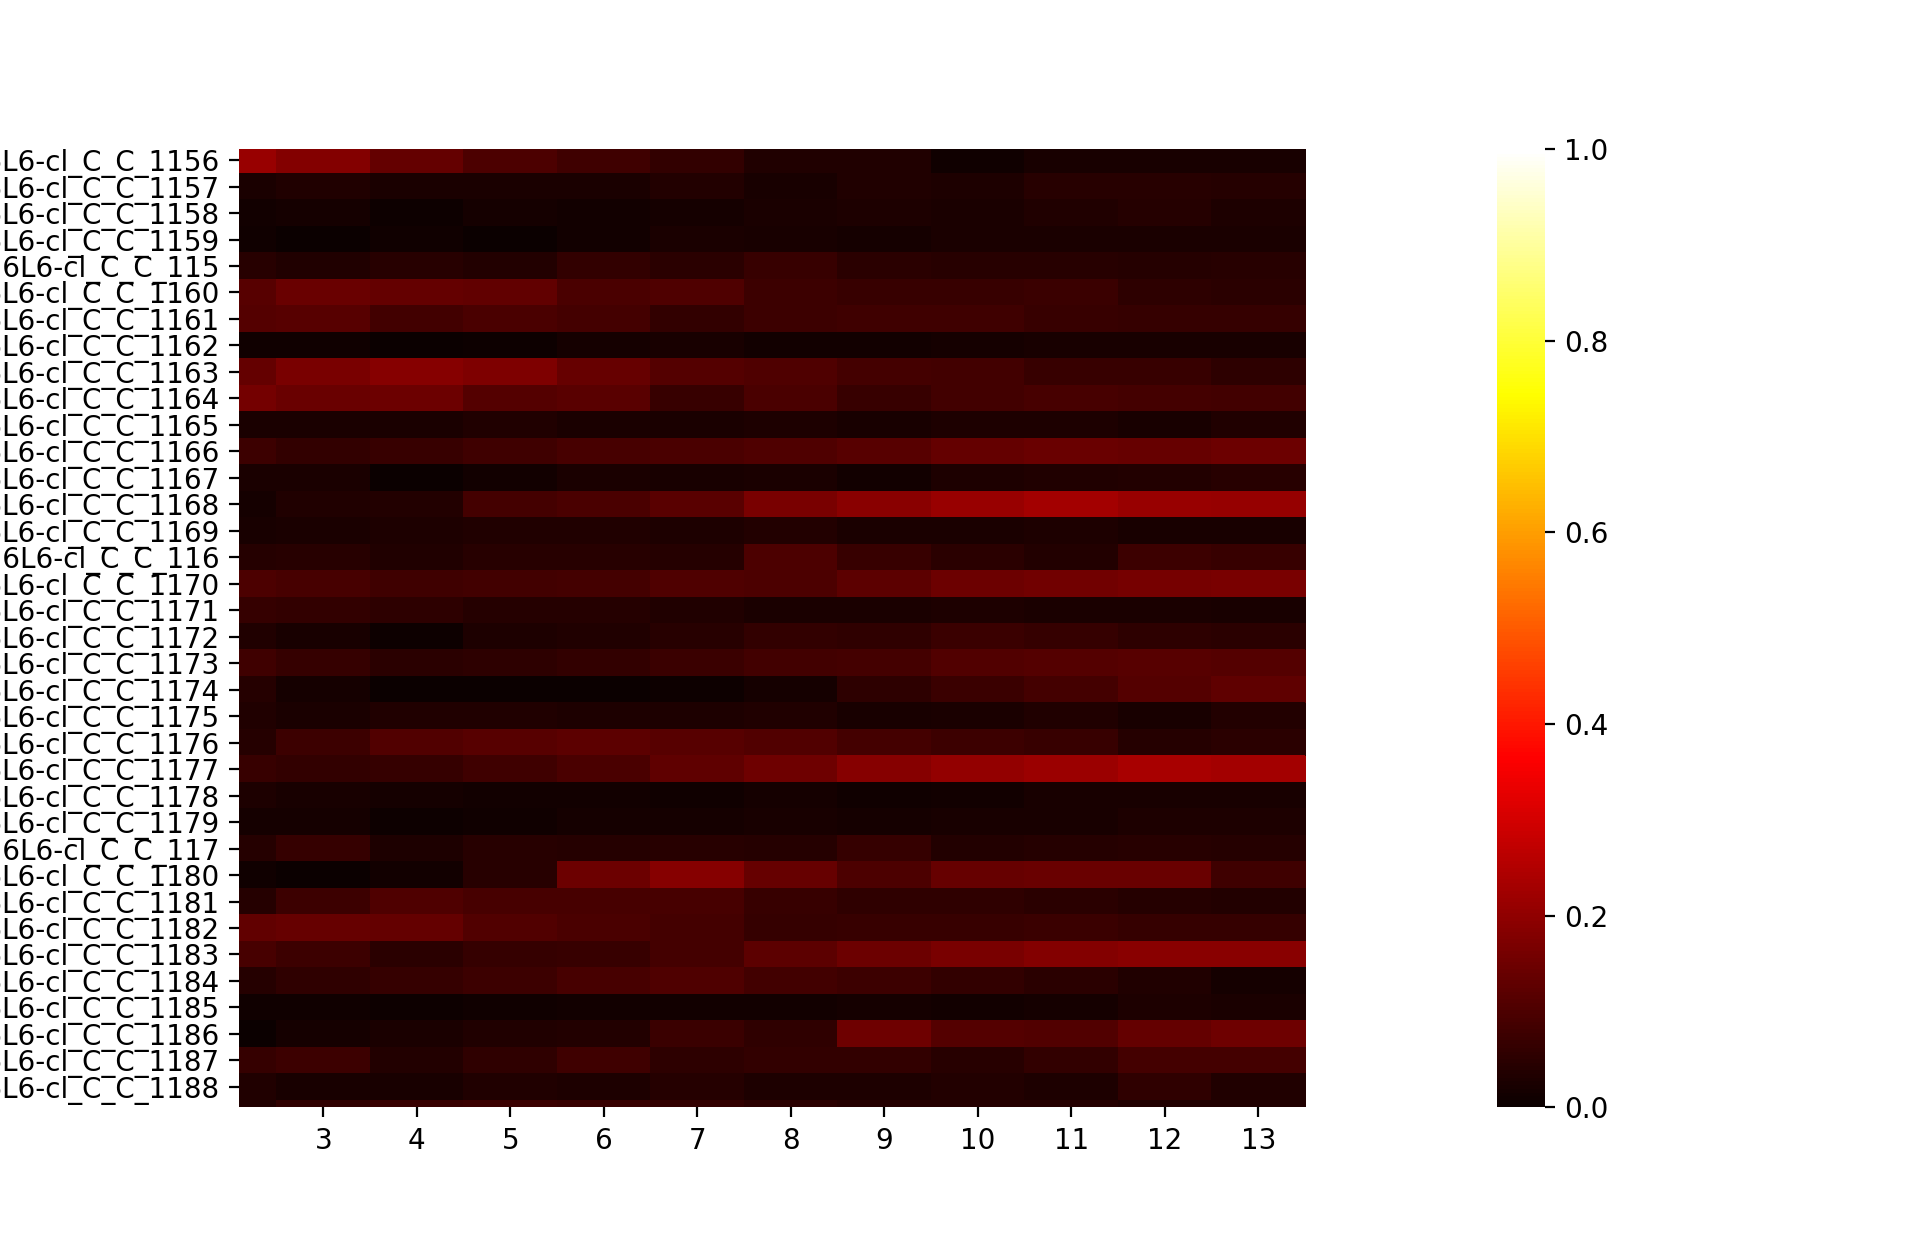

In [71]:
%matplotlib notebook 

ax = sns.heatmap(all_Ptrans_df_mean.T, vmin=0, vmax=1, cmap = 'hot', xticklabels=1, yticklabels=1)
plt.show()